In [1]:
import torch
import numpy as np
import math
from torch import nn

In [2]:
max_degree = 20
n_train,n_test = 100,100

true_w = np.zeros(max_degree)

In [3]:
# according to exercise
true_w[0:4] = np.array([5,1.2,-3.4,5.6])

features = np.random.normal(size=(n_train+n_test,1))

In [4]:
np.random.shuffle(features)

In [7]:
np.arange(max_degree).reshape(1,-1)

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19]])

In [8]:
poly_features = np.power(features, np.arange(max_degree).reshape(1,-1))

In [9]:
for i in range(max_degree):
    poly_features[:,i] /= math.gamma(i+1) # gamma is (n-1)!

In [12]:
labels = np.dot( poly_features, true_w)
labels.shape

(200,)

In [13]:
# adding epsilon noise
labels += np.random.normal(scale=0.1, size=labels.shape)

# what we generated was

# y = 5 + 1.2 * x  - 3.4 * x^2/2! + 5.6 * x^3/3! + epsilon 

In [14]:
# converting to tensor
true_w,features,poly_features, labels = [torch.tensor(x, dtype=torch.float32) for x in [true_w, features, poly_features, labels]]

In [15]:
features[:2], poly_features[:2,:], labels[:2]

(tensor([[-0.5207],
         [ 0.0419]]),
 tensor([[ 1.0000e+00, -5.2069e-01,  1.3556e-01, -2.3527e-02,  3.0626e-03,
          -3.1893e-04,  2.7677e-05, -2.0587e-06,  1.3399e-07, -7.7521e-09,
           4.0364e-10, -1.9106e-11,  8.2903e-13, -3.3205e-14,  1.2350e-15,
          -4.2868e-17,  1.3951e-18, -4.2728e-20,  1.2360e-21, -3.3872e-23],
         [ 1.0000e+00,  4.1863e-02,  8.7627e-04,  1.2228e-05,  1.2798e-07,
           1.0715e-09,  7.4761e-12,  4.4711e-14,  2.3397e-16,  1.0883e-18,
           4.5560e-21,  1.7339e-23,  6.0489e-26,  1.9479e-28,  5.8247e-31,
           1.6256e-33,  4.2534e-36,  1.0474e-38,  2.4360e-41,  5.3249e-44]]),
 tensor([3.6996, 5.2010]))

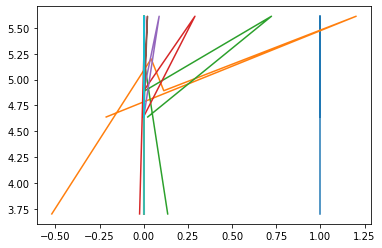

In [18]:
import  matplotlib.pyplot as plt

plt.plot(poly_features[:5], labels[:5])

In [16]:
def evaluate_loss(net, data_iter, loss):
    total_loss = 0
    total_len = 0
    for X,y in data_iter:
        y_hat = net(X)
        y = y.reshape(y_hat)
        l = loss(y_hat, y)
        total_loss += l
        total_len += l.numel()
    
    return total_loss/total_len
        

In [ ]:
def train(train_features, test_features, train_labels, test_labels, num_epochs=400):
    loss = nn.CrossEntropyLoss()
    input_shape = train_feature.shape[-1]
    print(f"input shape is : {input_shape}")
    net = nn.Sequential(nn.Linear(input_shape,1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = create_iter(train_features, train_labels.reshape(-1,1), batch_size)
    test_iter = create_iter(test_features, test_labels.reshape(-1,1), batch_size)
    
    optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
    
    # training loop
    
    for epoch in range(num_epochs):
        
        
        evaluate_loss(net,train_iter, loss)
        evaluate_loss(net, test_iter, loss)
    
    print("weight : ", net[0].weight.data.numpy())
    